# Traffic Simulation
### Notes:

<code>Original papers</code> 
- Nagel, K., Schreckenberg, M. (1992). A cellular automaton model for freeway traffic.  Journal de Physique I, 2(12), 2221–2229. Retrieved from: https://course-resources.minerva.kgi.edu/uploaded_files/mke/YpqvNV/nagel-schreckenberg.pdf
- Rickert, M., et al. (1996). Two lane traffic simulations using cellular automata. Physica A: Statistical Mechanics and its Applications, 231(4), 534–550. Retrieved from https://course-resources.minerva.kgi.edu/uploaded_files/mke/00100888-7879/rickert-et-al.pdf

The condistions for switching lanes:
1. If  velocity of the car is greater than the space ahead.
2. The other lane has space equal or greater than $v_o+1$
3. The space behind the car on the other lane is greater or equal to max speed $l_0 \geq v_max$

The update of the system consists of the following steps:
1. Acceleration: if the velocity $v$ is lower than $v_{max}$ and if the distance to the next car ahead is larger than $v+1$, the speed is advanced by one $v \rightarrow v+1$
2. Slowing down (due to other cars): if a vehicle at site $i$ sees the next vehicle at site $i+j$ (with $j\leq v$), it reduces the speed to $j-1$ as $v \rightarrow j-1$
3. Randomization: with probability $p$, the velocity of each vehicle (if greater than zero) is decreased by one $v \rightarrow v-1$
4. Car motion: each vehicle is advanced $v$ sites.

## Code:

In [1]:
# Importing packages
import numpy as np
import random as rn
import seaborn as sns
from matplotlib import rc
import matplotlib.pyplot as plt

rc('font',**{'family':'serif','serif':['Computer Modern'],'size': 16})
rc('text', usetex=True)

In [56]:
class TrafficSimulation:
    
    def __init__(self, length, density, v_max, p_slow, 
                 steps, lanes, warmup=0, switch=1):
        
        self.length = length   # Road length
        self.density = density # Traffic density
        self.v_max = v_max     # Maximum velocity
        self.p_slow = p_slow   # The probability of slowing down
        
        self.steps = steps     # The time steps of the simulation
        self.warmup = warmup   # The time steps for warmup
        self.lanes = lanes     # Number of lanes
        self.switch = switch   # Probability of switching lanes
        self.switchers = 0     # The number of cars that switched lanes
        self.flow = 0          # Traffic flow counter
        self.initialize_state()
        
        
    # Initializing a random configuration of cars
    def initialize_state(self):
        # Random pick of the initial position of cars
        idx = np.random.choice(range(self.lanes*self.length), 
                               int(self.density*self.length), False)
        # Fill the configuration dependent of road size and lanes
        self.state = np.full(self.lanes*self.length, -1)
        # Assing random velocities to the cars generated
        self.state[idx] = np.random.randint(0, self.v_max+1, len(idx))
        # Reshape the state to a nested list based on # of lanes
        self.state = self.state.reshape(self.lanes, self.length)
    
    
    def accelerate(self, cell):
        # If the car has speed 0 to 4 then accelerate
        if cell in range(self.v_max): cell+=1
        return cell
    
    
    def decelerate(self, idx, cell, lane):
        if cell>0:
            ahead = np.concatenate([self.state[lane, idx+1:], 
                    self.state[lane, 0:idx-1]])[:self.v_max]
            counter=0
            for next_cell in ahead:
                if next_cell>-1: break 
                else: counter+=1
            if counter<cell: cell=counter
        return cell
    
    
    # Randomizing the decrease in velocity
    def randomize(self, cell):
        # Randomly deccelerate a car with probability p_slow
        if cell>0 and rn.random() <= self.p_slow: cell-=1
        return cell
    
    
    # Switching lanes 
    def change_lane(self):
        # Stores a version of the current configuration
        new_state = self.state.copy()
        
        for lane in range(self.lanes):
            # Returns a list with the gap between the cars in lane
            spaces = np.ediff1d(np.nonzero(self.state[lane]+1))
            # Append the periodic space
            count = 0
            for _ in range(len(self.state[lane])): 
                if (self.state[lane]+1)[-_+1] == 0: count+=1
                elif (self.state[lane]+1)[_] == 0: count+=1
                else: break
            # Spaces contains all gaps between cars
            spaces = np.append(spaces-1, count)
            
            
            # Retrieves the indices of the cars in the lane
            cars_idx = np.nonzero(self.state[lane] != -1)[0]
            #np.array([i for i,val in enumerate(state) if val!= -1])
            #np.nonzero(self.state[lane] != -1)[0]
            #np.array([i for i,val in enumerate(self.state[lane]) if val!= -1])
            
            
            # Checks if the velocity of the cars is greater than the space in front
            changers = cars_idx[self.state[lane, cars_idx]>spaces]
            # Loops through all cars to check for the lane switching conditions
                # If the If velocity of the car is greater than the space ahead.
                # The other lane has space equal or greater than v+1
                # The space behind the car on the other lane is >= v_max
            changers = [car for car in changers 
                        if (self.state[(lane+1)%self.lanes, 
                        np.arange(car-self.v_max, 
                        car+self.state[lane, car]+1)%self.length]==-1).all()]
            
            # Move switching cars to the new configuration
            new_state[lane,changers] = np.full((1,len(changers)),-1)
            new_state[(lane+1)%self.lanes,changers] = self.state[lane,changers]
        
        # Count the number of lane switching
        self.switchers+= len(changers)
        self.state = new_state
    
    
    # Move the traffic based on cars' velocities
    def move(self):
        # Create an array for the new state
        new_state = np.full((self.lanes, self.length), -1)
        for lane in range(self.lanes):
            for idx,cell in enumerate(self.state[lane]):
                # Start recording the flow after N warmup time steps
                if (idx+cell)>self.length-1 and self.steps>self.warmup: self.flow+=1
                # Move cars dependent on their velocity
                if cell>-1: new_state[lane, (idx+cell)%self.length]=cell
        # Update the configuration of traffic
        self.state = new_state
    
    def update(self, display):
        # Display the current configuration of traffic
        if display: self.display()
        
        self.change_lane()
        # Update every single car
        for lane in range(self.lanes):
            for cell in range(len(self.state[lane])):
                self.state[lane,cell] = self.accelerate(self.state[lane,cell])
                self.state[lane,cell] = self.decelerate(cell,self.state[lane,cell],lane)
                self.state[lane,cell] = self.randomize(self.state[lane,cell])
        
        # Move the traffic based on the cars' velocities
        self.move()

    # Function to specify the output of the simulation
    def output(self, display=False):
        for i in range(self.steps):
            self.update(display)

    
    def display(self):
        # Print the configuration of traffic for each state
        """
        OPTION 1: Using the print function
        for lane in range(self.lanes):
            print("".join('.' if x == -1 else str(x) for x in self.state[lane]))
            
        OPTION 2: Using heatmaps
        """
        plt.figure(figsize=(20, .5+(.5*self.lanes)))
        sns.heatmap(np.where(self.state==-1, np.nan, self.state),
                    square=True,cmap="RdYlGn", vmin=0, vmax=5, 
                    cbar=False, xticklabels=False, yticklabels=False,
                    linewidths=1, linecolor='black', alpha=.7)
        plt.show()

## Part I: Traffic jams on a circular road

Use the following model parameters for the first figure.
- Road length: 100
- Traffic density: 0.03
- Maximum velocity: 5
- Probability of slowing down: 0.5


Use these model parameters for the second figure. (The traffic density is different.)
- Road length: 100
- Traffic density: 0.1
- Maximum velocity: 5
- Probability of slowing down: 0.5

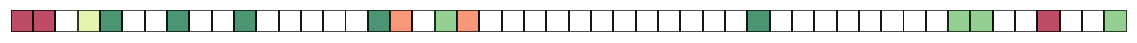

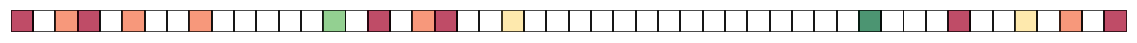

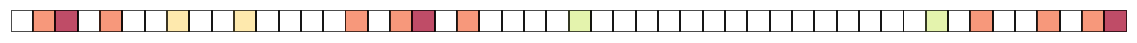

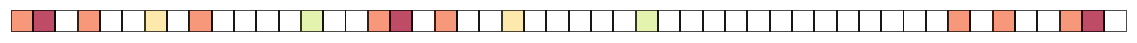

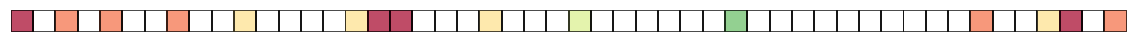

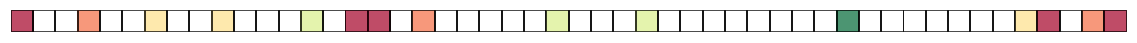

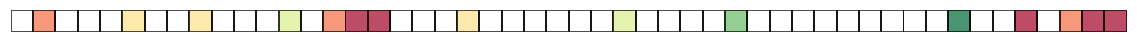

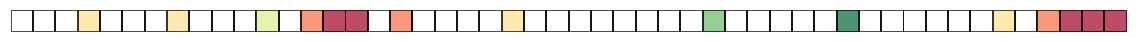

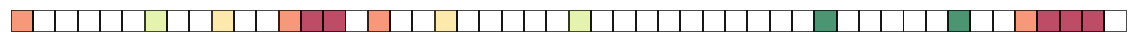

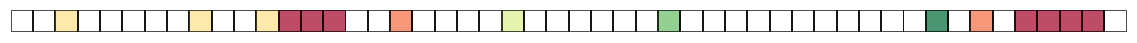


The number of cars crossing the end:  2 After time steps:  10


In [57]:
# (length, density, v_max, p_slow, steps, lanes, warmup=0, change=1)
Sim = TrafficSimulation(50, .3, 5, .2, 10, 1)
Sim.output(display=True)
print('\nThe number of cars crossing the end: ', Sim.flow,
      'After time steps: ', Sim.steps)

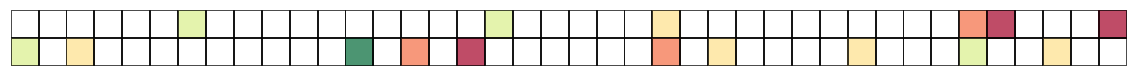

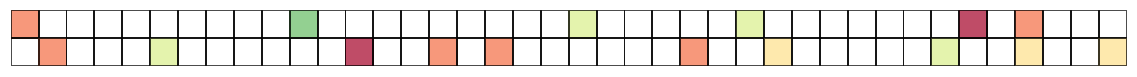

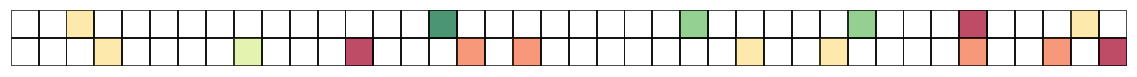

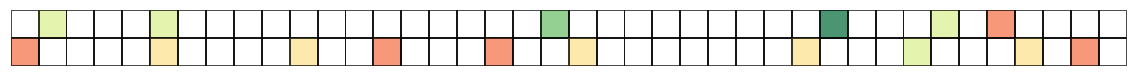

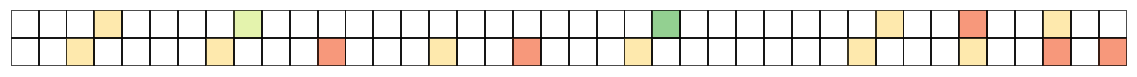

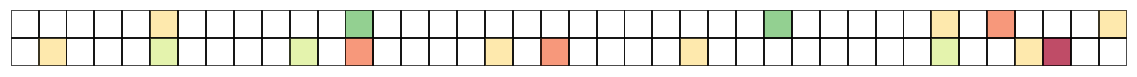

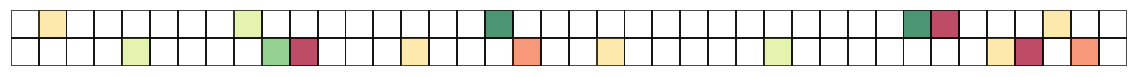

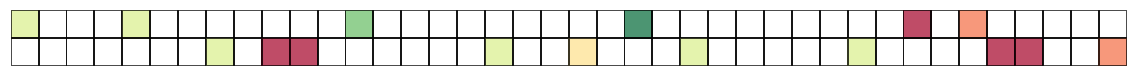

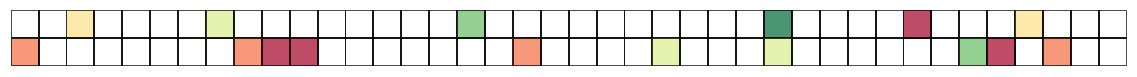

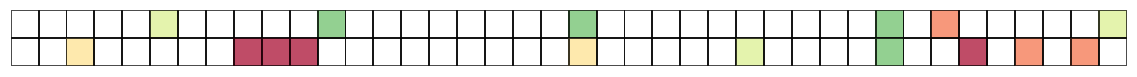


The number of cars crossing the end:  9 After time steps:  10


In [58]:
# (length, density, v_max, p_slow, steps, lanes, warmup=0, change=1)
Sim = TrafficSimulation(40, .4, 5, .5, 10, 2)
Sim.output(display=True)
print('\nThe number of cars crossing the end: ', Sim.flow,
      'After time steps: ', Sim.steps)

In [96]:
# SIMULATION FOR MULTIPLE DENSITIES

def simulation(Flow, CI, Lanes):
    # Set the initial conditions
    global den_list
    den_list = np.linspace(0, 1*Lanes, 100)
    road_length = 100
    max_velocity = 5
    proba_slow = .5
    time_steps = 250
    warmup = 50
    if Lanes>1:
        global Swi
        Swi = []
    
    # Produce the flow vs. density graph
    for density in den_list:
        # Temporary list to register the Flow/Timestep
        temp, temp_s = [], []
        for _ in range(50):
            # Run the simulation for the given parameters
            sim = TrafficSimulation(road_length, density, 
                                    max_velocity, proba_slow, 
                                    time_steps, Lanes, warmup)
            sim.output(display=False)
            if Lanes>1: temp_s.append(sim.switchers)
            temp.append(sim.flow / (sim.steps-sim.warmup))
        
        # Record the results of the simulation [Flow & CI]
        CI.append((np.percentile(temp, 97.5)-np.percentile(temp, 2.5))/2)
        Flow.append(np.mean(temp)/Lanes)
        if Lanes>1: Swi.append(np.mean(temp_s))
    #if Lanes>1: return Flow, CI, Swi
    #else: return Flow, CI

In [97]:
# PLOTTING THE FLOW V DENSITY FOR THE SIMULATION

def plotting_result(Flow, CI, Title, Lanes):
    plt.figure(facecolor='w', figsize=(12, 10))
    plt.errorbar(np.array(den_list)/Lanes, Flow, yerr=CI, capsize=2)
    plt.plot(np.array(den_list)/Lanes, Flow, 'k.')
    #plt.plot(den_list, Flow)
    #plt.scatter(den_list, Flow)

    plt.title('Simulation {}'.format(Title), fontsize=26)
    plt.xlabel('Density [car per site]', fontsize=18)
    plt.ylabel('Flow [car per time step]', fontsize=18)
    plt.show()

In [98]:
flow_rate1, conf95_1 = [], []
simulation(flow_rate1, conf95_1, 1)

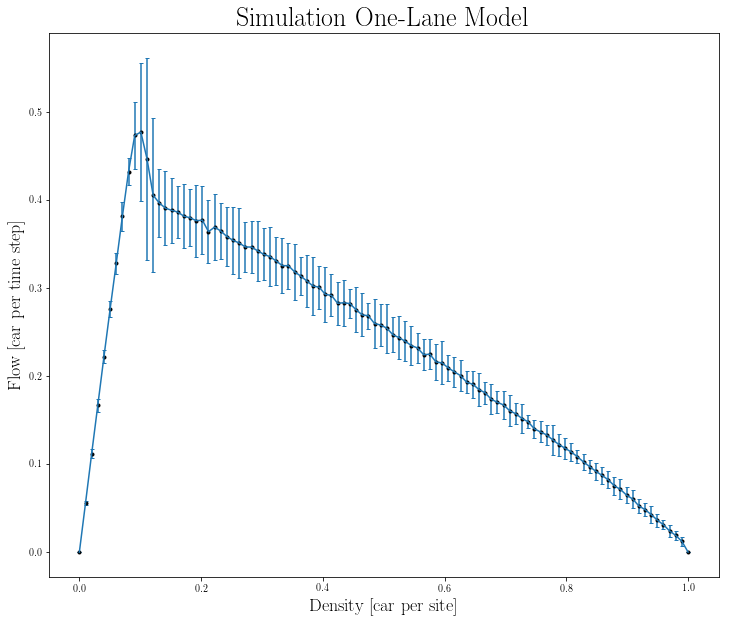

In [99]:
plotting_result(flow_rate1, conf95_1, 'One-Lane Model', 1)

## Part II: Multi-lane highways

In [100]:
flow_rate2, conf95_2 = [], []
sim_2 = simulation(flow_rate2, conf95_2, 2)

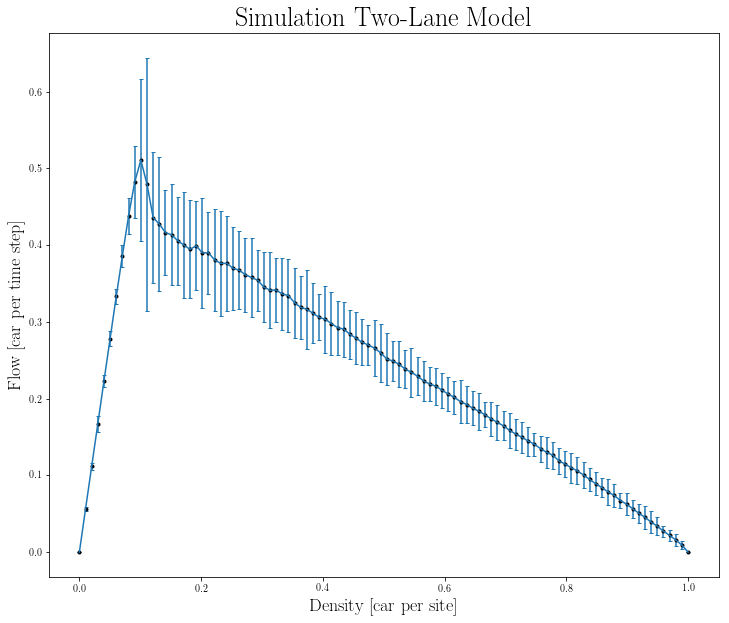

In [101]:
plotting_result(flow_rate2, conf95_2, 'Two-Lane Model', 2)

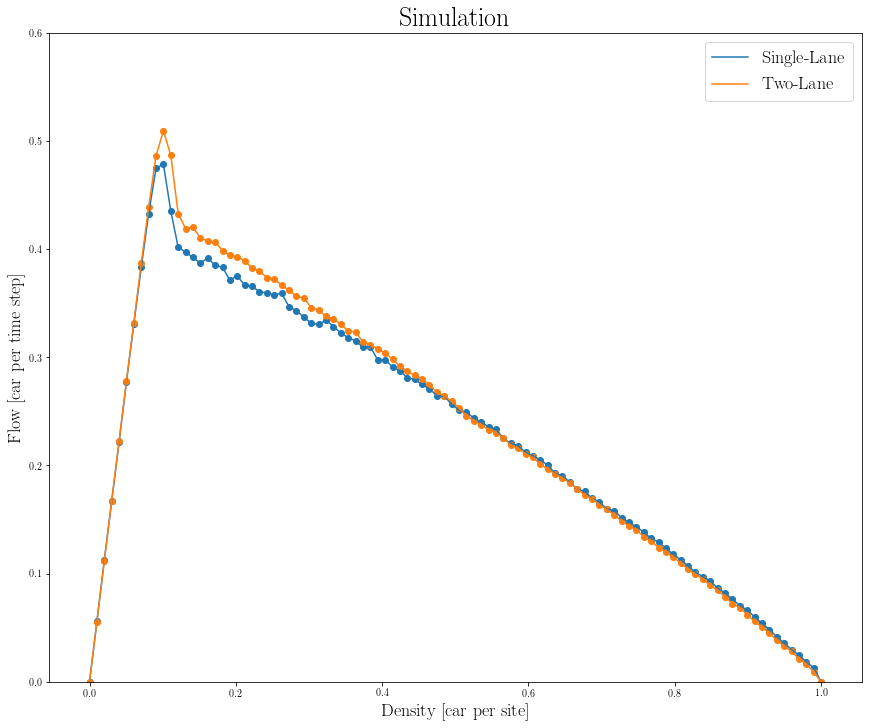

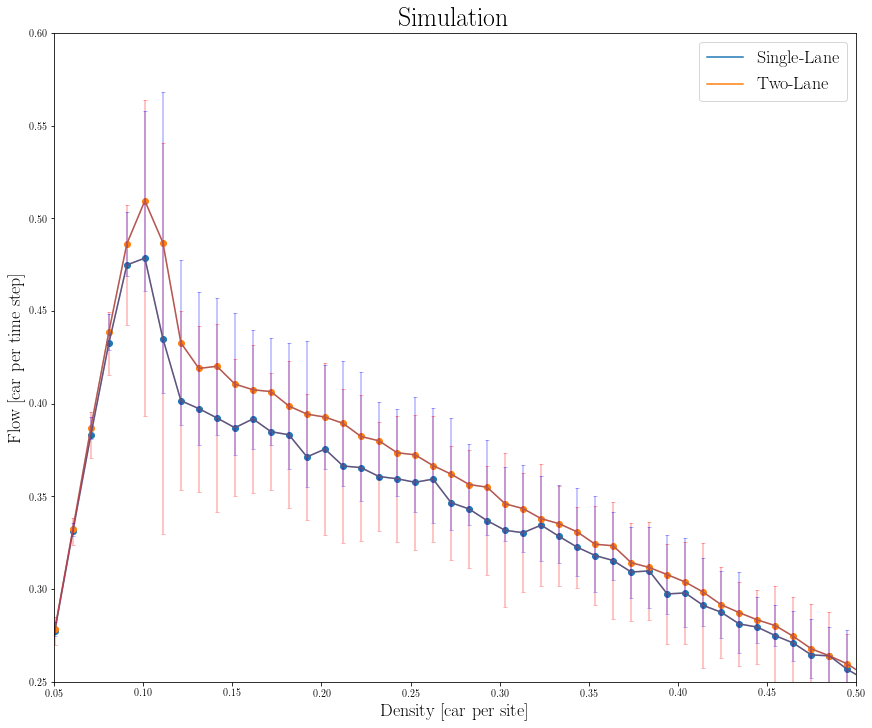

In [482]:
plt.figure(facecolor='w', figsize=(12, 10))

plt.plot(np.array(den_list)/2, flow_rate1, label='Single-Lane')
plt.scatter(np.array(den_list)/2, flow_rate1)

plt.plot(np.array(den_list)/2, np.array(flow_rate2)/2, label='Two-Lane')
plt.scatter(np.array(den_list)/2, np.array(flow_rate2)/2)

plt.title('Simulation' , fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=18)
plt.ylim(0, 0.6)

plt.show()

plt.figure(facecolor='w', figsize=(12, 10))

plt.plot(np.array(den_list)/2, flow_rate1, label='Single-Lane')
plt.scatter(np.array(den_list)/2, flow_rate1)
plt.errorbar(np.array(den_list)/2, flow_rate1, 
             yerr=conf95_1, capsize=2, alpha=.3, color='red')

plt.plot(np.array(den_list)/2, np.array(flow_rate2)/2, label='Two-Lane')
plt.scatter(np.array(den_list)/2, np.array(flow_rate2)/2)
plt.errorbar(np.array(den_list)/2, np.array(flow_rate2)/2, 
             yerr=np.array(conf95_2)/2, capsize=2, alpha=.3, color='blue')

plt.title('Simulation' , fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=18)
plt.xlim(.05, .5)
plt.ylim(.25, .6)
plt.show()

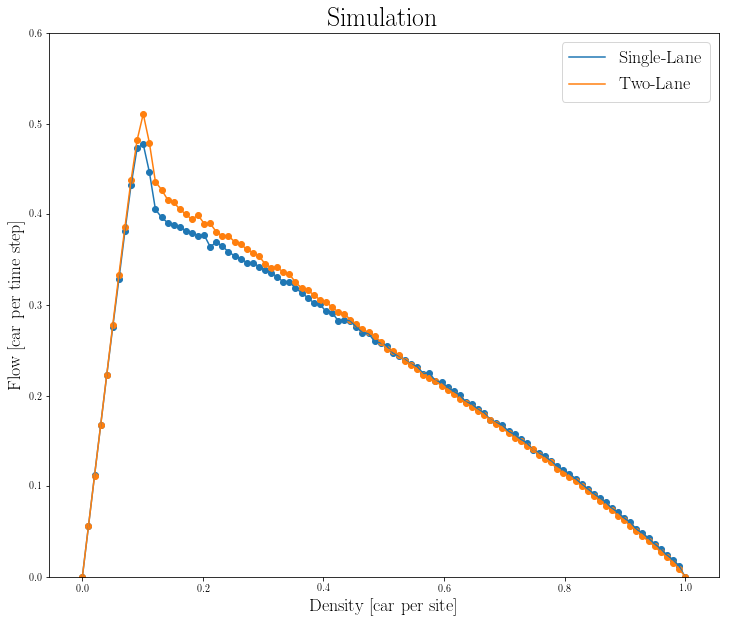

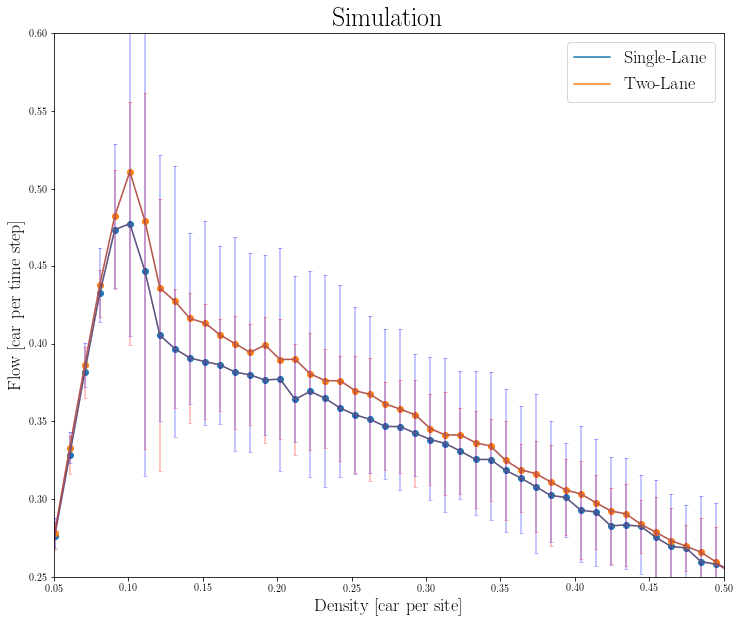

In [106]:
plt.figure(facecolor='w', figsize=(12, 10))

plt.plot(np.array(den_list)/2, flow_rate1, label='Single-Lane')
plt.scatter(np.array(den_list)/2, flow_rate1)

plt.plot(np.array(den_list)/2, flow_rate2, label='Two-Lane')
plt.scatter(np.array(den_list)/2, flow_rate2)

plt.title('Simulation' , fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=18)
plt.ylim(0, 0.6)

plt.show()

plt.figure(facecolor='w', figsize=(12, 10))

plt.plot(np.array(den_list)/2, flow_rate1, label='Single-Lane')
plt.scatter(np.array(den_list)/2, flow_rate1)
plt.errorbar(np.array(den_list)/2, flow_rate1, 
             yerr=conf95_1, capsize=2, alpha=.3, color='red')

plt.plot(np.array(den_list)/2, flow_rate2, label='Two-Lane')
plt.scatter(np.array(den_list)/2, flow_rate2)
plt.errorbar(np.array(den_list)/2, flow_rate2, 
             yerr=conf95_2, capsize=2, alpha=.3, color='blue')

plt.title('Simulation' , fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=18)
plt.xlim(.05, .5)
plt.ylim(.25, .6)
plt.show()

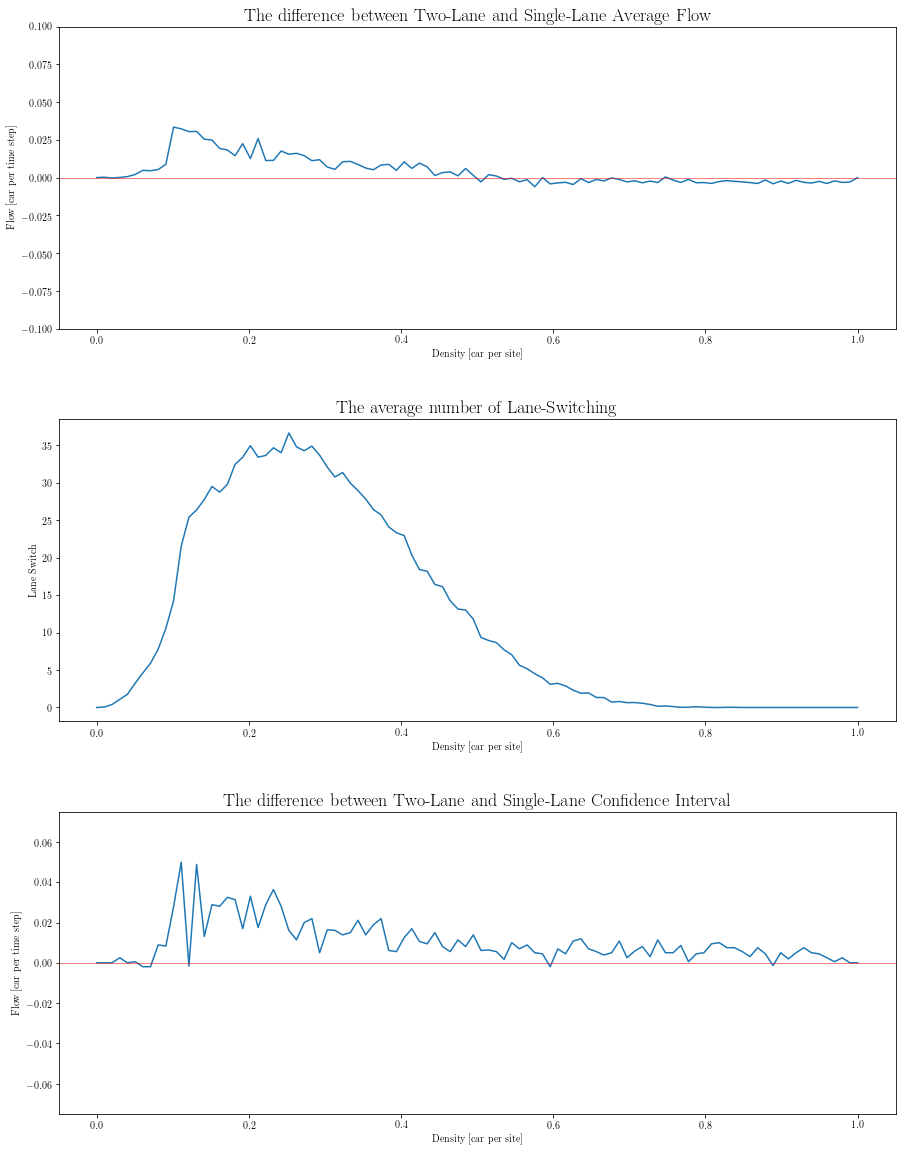

In [108]:
plt.figure(figsize=(15, 20))
plt.subplots_adjust(hspace=.3)


plt.subplot(3,1,1)
plt.title('The difference between Two-Lane and Single-Lane Average Flow',
         fontsize=18)
plt.plot(np.array(den_list)/2,(np.array(flow_rate2)-np.array(flow_rate1)))
plt.ylabel('Flow [car per time step]')
plt.xlabel('Density [car per site]')
plt.ylim(-.1, .1)
plt.axhline(0, linewidth=.5, color='red')


plt.subplot(3,1,2)
plt.title('The average number of Lane-Switching',
         fontsize=18)
plt.plot(np.array(den_list)/2, Swi)
plt.xlabel('Density [car per site]')
plt.ylabel('Lane Switch')


plt.subplot(3,1,3)
plt.title('The difference between Two-Lane and Single-Lane Confidence Interval',
         fontsize=18)
plt.plot(np.array(den_list)/2,(np.array(conf95_2)-np.array(conf95_1)))
plt.axhline(0, linewidth=.5, color='red')
plt.ylim(-.075, .075)
plt.ylabel('Flow [car per time step]')
plt.xlabel('Density [car per site]')
plt.show()

In [ ]:
"""
Caption: Visualizing differences: Figure I is illustrating the average flow difference between 
the Single-Lane and Two-Lane model.
Figure II: Graph showing the average of lane switching occurances at each density for the Two-Lane model
Figure III: illustrating the confidence interval difference between the Single-Lane and Two-Lane model
"""

## Three-Lane model

In [111]:
flow_rate3, conf95_3 = [], []
simulation(flow_rate3, conf95_3, 3)

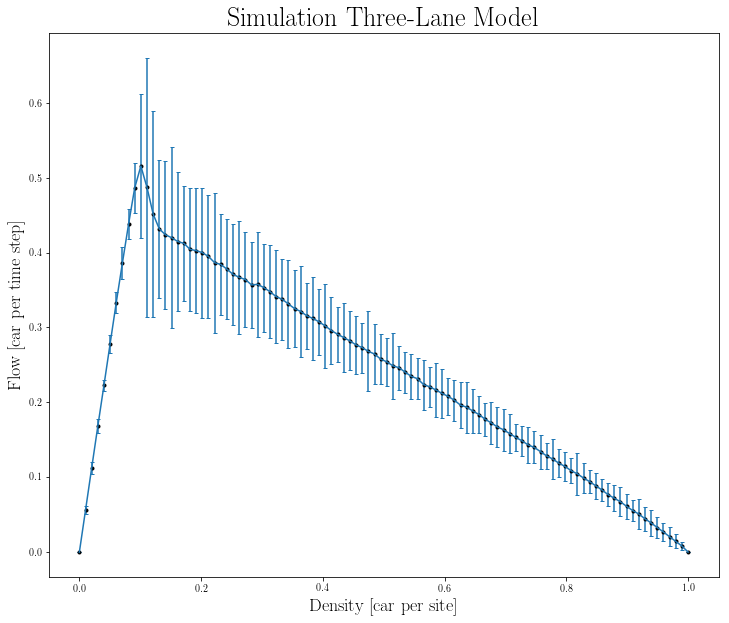

In [113]:
plotting_result(flow_rate3, conf95_3, 'Three-Lane Model', 3)

In [149]:
# BEST FLOW FOR EACH OF THE MODELS
print('At {} density the max flow of One-Lane model {}'.format(
       .01*np.argmax(flow_rate1), max(flow_rate1)),
      '\nAt {} density the max flow of Two-Lane model {}'.format(
       .01*np.argmax(np.array(flow_rate2)), max(np.array(flow_rate2))),
     '\nAt {} density the max flow of Three-Lane model {}'.format(
       .01*np.argmax(np.array(flow_rate3)), max(np.array(flow_rate3))))

At 0.1 density the max flow of One-Lane model 0.47740000000000005 
At 0.1 density the max flow of Two-Lane model 0.51085 
At 0.1 density the max flow of Three-Lane model 0.5155666666666667


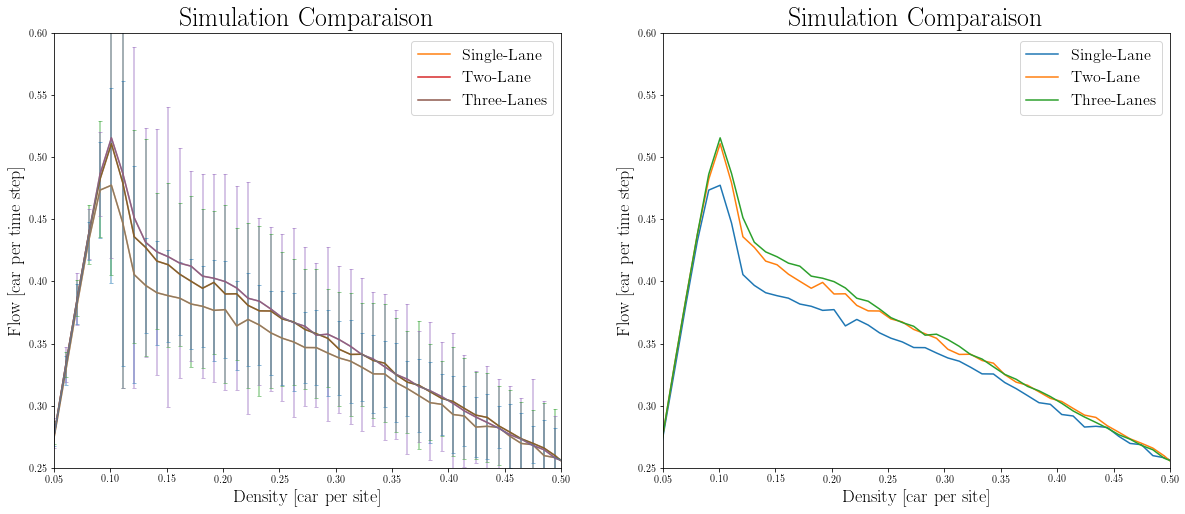

In [126]:
# PLOTTING THE FLOW V DENSITY FOR THE SIMULATION

plt.figure(facecolor='w', figsize=(20, 8))

def plotting_all_result(Flow, CI, Lanes, Label):
    plt.errorbar(np.array(den_list)/3, Flow, yerr=CI, capsize=2, alpha=.5)
    plt.plot(np.array(den_list)/3, Flow, label=Label)
    plt.xlim(.05, .5)
    plt.ylim(.25, .6)
    
def plotting_all_result_(Flow, CI, Lanes, Label):
    plt.plot(np.array(den_list)/3, Flow, label=Label)
    plt.xlim(.05, .5)
    plt.ylim(.25, .6)
    
    
plt.subplot(1,2,1)
plotting_all_result(flow_rate1, conf95_1, 1, 'Single-Lane')
plotting_all_result(flow_rate2, conf95_2, 2, 'Two-Lane')
plotting_all_result(flow_rate3, conf95_3, 3, 'Three-Lanes')
plt.title('Simulation Comparaison', fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)

plt.subplot(1,2,2)
plotting_all_result_(flow_rate1, conf95_1, 1, 'Single-Lane')
plotting_all_result_(flow_rate2, conf95_2, 2, 'Two-Lane')
plotting_all_result_(flow_rate3, conf95_3, 3, 'Three-Lanes')
plt.title('Simulation Comparaison', fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)
plt.show()

## Testing the hypopthesis
In the report, the claim was that if the random slow down was set to be zero then -in the long run- adding multiple lanes is just equivalent to adding a separated single lane and the average flow for n lanes is just the same as n times the average flow of a single lane. In other words:
$$\overline{flow}\left(N \times lanes\right) = N\times\overline{flow}\left(Single\right)$$

In [127]:
def simulation_(Flow, CI, Lanes):
    # Set the initial conditions
    global den_list
    den_list = np.linspace(0, 1*Lanes, 100)
    road_length = 100
    max_velocity = 5
    proba_slow = 0
    time_steps = 150
    warmup = 50
    if Lanes>1:
        global Swi
        Swi = []
    
    # Produce the flow vs. density graph
    for density in den_list:
        # Temporary list to register the Flow/Timestep
        temp, temp_s = [], []
        for _ in range(20):
            # Run the simulation for the given parameters
            sim = TrafficSimulation(road_length, density, 
                                    max_velocity, proba_slow, 
                                    time_steps, Lanes, warmup)
            sim.output(display=False)
            if Lanes>1: temp_s.append(sim.switchers)
            temp.append(sim.flow / (sim.steps-sim.warmup))
        
        # Record the results of the simulation [Flow & CI]
        CI.append((np.percentile(temp, 97.5)-np.percentile(temp, 2.5))/2)
        Flow.append(np.mean(temp)/Lanes)
        if Lanes>1: Swi.append(np.mean(temp_s))
    #if Lanes>1: return Flow, CI, Swi
    #else: return Flow, CI

In [128]:
flow_rate1_, conf95_1_ = [], []
simulation_(flow_rate1_, conf95_1_, 1)

In [129]:
flow_rate2_, conf95_2_ = [], []
simulation_(flow_rate2_, conf95_2_, 2)

In [130]:
flow_rate3_, conf95_3_ = [], []
simulation_(flow_rate3_, conf95_3_, 3)

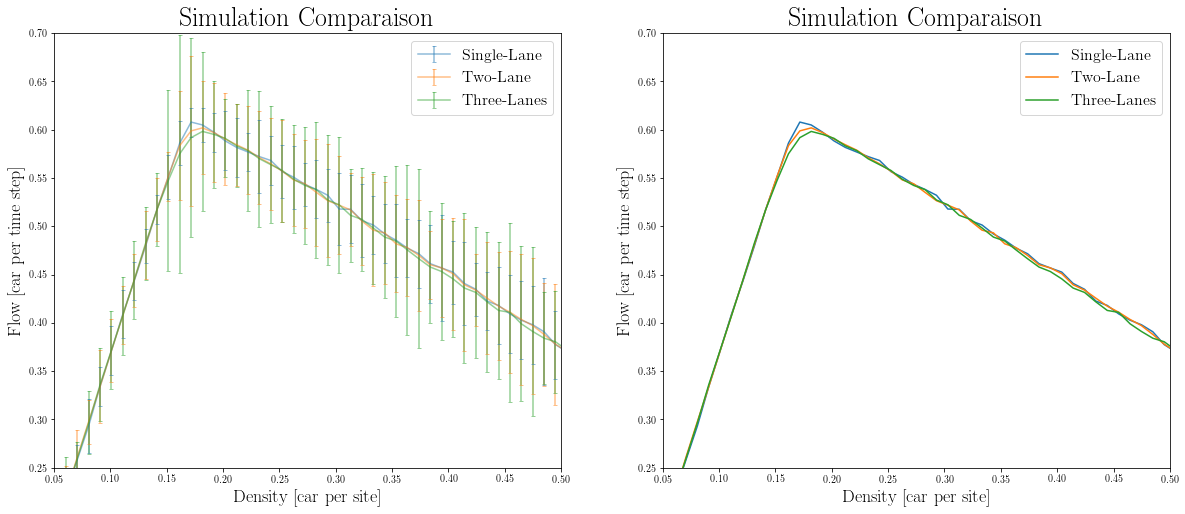

In [145]:
# PLOTTING THE FLOW V DENSITY FOR THE SIMULATION

plt.figure(facecolor='w', figsize=(20, 8))
    
plt.subplot(1,2,1)
plt.errorbar(np.array(den_list)/3, np.array(flow_rate1_)/2,
             yerr=conf95_1_, capsize=2, alpha=.5, label='Single-Lane')
plt.errorbar(np.array(den_list)/3, np.array(flow_rate2_)/2,
             yerr=conf95_2_, capsize=2, alpha=.5, label='Two-Lane')
plt.errorbar(np.array(den_list)/3, np.array(flow_rate3_)/2,
             yerr=conf95_3_, capsize=2, alpha=.5, label='Three-Lanes')
plt.xlim(.05, .5)
plt.ylim(.25, .7)
plt.title('Simulation Comparaison', fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)

plt.subplot(1,2,2)
plt.plot(np.array(den_list)/3, np.array(flow_rate1_)/2, label='Single-Lane')
plt.plot(np.array(den_list)/3, np.array(flow_rate2_)/2, label='Two-Lane')
plt.plot(np.array(den_list)/3, np.array(flow_rate3_)/2, label='Three-Lanes')
plt.xlim(.05, .5)
plt.ylim(.25, .7)
plt.title('Simulation Comparaison', fontsize=26)
plt.xlabel('Density [car per site]', fontsize=18)
plt.ylabel('Flow [car per time step]', fontsize=18)
plt.legend(loc='upper right', fontsize=16)
plt.show()

## Part III: Future extentions

Model extension ideas

Other ways of measuring whether traffic is good or bad:
- Traffic flow
- Count accidents [Not necessary]
- Length of traffic jams
- Time to travel from start to end of road (high average speed)
- Variation in velocity
- Overall average speed of all cars on the road
- Proportion of stationary cars

Extensions to the traffic model to make it more realistic:
- Intersections – 2-d grid with road cells and non-road cells [Not necessary]
- More lanes
- Different max speeds for different cars: old car vs modern sports car
- Probability of collisions [Not necessary]

Extensions to the driver behavior model to make it more realistic:
- Probability of slowdown can be dynamic – time of day / animals on the road